# Model Performance Analysis & Diagnostics

This notebook performs a comprehensive analysis of the trained cinema audience forecasting model to:
1. Evaluate prediction accuracy and identify weaknesses
2. Analyze errors by different segments (theaters, time periods, audience sizes)
3. Visualize prediction patterns and residuals
4. Determine if improvements are needed and where to focus

**Goal**: Understand if current accuracy is sufficient or if we need model improvements

## Step 1: Load Required Libraries and Data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries loaded!")

✓ Libraries loaded!


## Step 2: Load Predictions and Actual Values

We need to load the validation predictions from the trained model to analyze performance.

In [33]:
# Note: You'll need to run the main notebook first and save validation results
# For now, let's load the original data and recreate the analysis

print("Loading datasets...")
DATA_PATH = '../dataset/'

# Load original data
booknow_booking = pd.read_csv(DATA_PATH + 'booknow_booking/booknow_booking.csv')
booknow_visits = pd.read_csv(DATA_PATH + 'booknow_visits/booknow_visits.csv')
booknow_theaters = pd.read_csv(DATA_PATH + 'booknow_theaters/booknow_theaters.csv')
date_info = pd.read_csv(DATA_PATH + 'date_info/date_info.csv')

print(f"✓ Data loaded!")
print(f"Booking data: {booknow_booking.shape}")
print(f"Visits data: {booknow_visits.shape}")
print(f"Theaters data: {booknow_theaters.shape}")
print(f"Date info: {date_info.shape}")

Loading datasets...
✓ Data loaded!
Booking data: (68336, 4)
Visits data: (214046, 3)
Theaters data: (829, 5)
Date info: (547, 2)
✓ Data loaded!
Booking data: (68336, 4)
Visits data: (214046, 3)
Theaters data: (829, 5)
Date info: (547, 2)


## Step 3: Quick Data Exploration & Statistics

In [34]:
# Merge basic data
df = booknow_booking.copy()

# Dynamically detect column names
print("Detecting column names...")
print(f"Available columns: {df.columns.tolist()}\n")

# Find date column
date_col = None
for col in df.columns:
    if 'date' in col.lower() and 'booking' not in col.lower():
        date_col = col
        break

if date_col is None:
    # Try common alternatives
    for col in ['show_date', 'date', 'showing_date', 'show_datetime', 'Date', 'SHOW_DATE']:
        if col in df.columns:
            date_col = col
            break

# Find booking date column
booking_date_col = None
for col in df.columns:
    if 'booking' in col.lower() and 'date' in col.lower():
        booking_date_col = col
        break

# Find theater ID column
theater_id_col = None
for col in df.columns:
    if 'theater' in col.lower() and 'id' in col.lower():
        theater_id_col = col
        break

# Find target column (audience_count or tickets_booked)
target_col = None
for col in ['audience_count', 'tickets_booked', 'audience', 'tickets']:
    if col in df.columns:
        target_col = col
        break

print(f"Detected columns:")
print(f"  • Date column: {date_col}")
print(f"  • Booking date column: {booking_date_col}")
print(f"  • Theater ID column: {theater_id_col}")
print(f"  • Target column: {target_col}\n")

# Standardize column names for easier analysis
if date_col and date_col != 'show_date':
    df['show_date'] = df[date_col]
elif date_col is None:
    print("⚠️ WARNING: Could not find date column!")
    
if booking_date_col and booking_date_col != 'booking_date':
    df['booking_date'] = df[booking_date_col]
    
if theater_id_col and theater_id_col != 'book_theater_id':
    df['book_theater_id'] = df[theater_id_col]

# Standardize target column name
if target_col and target_col != 'audience_count':
    df['audience_count'] = df[target_col]
    print(f"📊 Using '{target_col}' as target variable (renamed to 'audience_count' for analysis)")
elif target_col is None:
    print("⚠️ WARNING: Could not find target column (audience_count or tickets_booked)!")

# Convert dates
if 'show_date' in df.columns:
    df['show_date'] = pd.to_datetime(df['show_date'])
if 'booking_date' in df.columns:
    df['booking_date'] = pd.to_datetime(df['booking_date'])

# Basic statistics
print("\n" + "=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nTotal records: {len(df):,}")

if 'show_date' in df.columns:
    print(f"Date range: {df['show_date'].min()} to {df['show_date'].max()}")
    print(f"Number of days covered: {(df['show_date'].max() - df['show_date'].min()).days}")

if 'book_theater_id' in df.columns:
    print(f"Number of unique theaters: {df['book_theater_id'].nunique()}")

if 'audience_count' in df.columns:
    print(f"\n{target_col.upper()} Statistics:")
    print(df['audience_count'].describe())
    print(f"\nMissing values: {df['audience_count'].isna().sum():,} ({df['audience_count'].isna().sum()/len(df)*100:.2f}%)")
else:
    print("\n⚠️ WARNING: Target column not found in dataset!")

Detecting column names...
Available columns: ['book_theater_id', 'show_datetime', 'booking_datetime', 'tickets_booked']

Detected columns:
  • Date column: show_datetime
  • Booking date column: booking_datetime
  • Theater ID column: book_theater_id
  • Target column: tickets_booked

📊 Using 'tickets_booked' as target variable (renamed to 'audience_count' for analysis)

DATASET OVERVIEW

Total records: 68,336
Date range: 2023-01-01 19:00:00 to 2024-02-28 23:00:00
Number of days covered: 423
Number of unique theaters: 301

TICKETS_BOOKED Statistics:
count    68336.000000
mean         4.425808
std          4.808945
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        100.000000
Name: audience_count, dtype: float64

Missing values: 0 (0.00%)


## 🔍 DIAGNOSTIC: Target Variable Validation

**Critical Check**: Verify we're using the correct target variable and that the mean audience count is realistic.

In [35]:
print("="*80)
print("🔍 DIAGNOSTIC: CHECKING TARGET VARIABLE")
print("="*80)

# Check all numeric columns and their statistics
print("\n📊 ALL NUMERIC COLUMNS IN DATASET:")
print("-" * 80)
numeric_cols_found = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        mean_val = df[col].mean()
        median_val = df[col].median()
        min_val = df[col].min()
        max_val = df[col].max()
        print(f"{col:35s}: Mean={mean_val:>10.2f} | Median={median_val:>10.2f} | Min={min_val:>10.2f} | Max={max_val:>10.2f}")
        numeric_cols_found.append(col)

print("\n" + "="*80)
print("🎯 TARGET VARIABLE ANALYSIS")
print("="*80)

# Check what we're actually predicting
if 'audience_count' in df.columns:
    df_train = df[df['audience_count'].notna()].copy()
    
    print(f"\n✓ Found 'audience_count' column")
    print(f"\n{'DETAILED STATISTICS':=^80}")
    print(f"  • Total records: {len(df_train):,}")
    print(f"  • Mean: {df_train['audience_count'].mean():.2f}")
    print(f"  • Median: {df_train['audience_count'].median():.2f}")
    print(f"  • Standard Deviation: {df_train['audience_count'].std():.2f}")
    print(f"  • Min: {df_train['audience_count'].min():.0f}")
    print(f"  • Max: {df_train['audience_count'].max():.0f}")
    print(f"  • 25th percentile: {df_train['audience_count'].quantile(0.25):.2f}")
    print(f"  • 50th percentile: {df_train['audience_count'].quantile(0.50):.2f}")
    print(f"  • 75th percentile: {df_train['audience_count'].quantile(0.75):.2f}")
    print(f"  • 90th percentile: {df_train['audience_count'].quantile(0.90):.2f}")
    print(f"  • 99th percentile: {df_train['audience_count'].quantile(0.99):.2f}")
    
    print(f"\n{'SAMPLE VALUES (First 30)':=^80}")
    print(df_train['audience_count'].head(30).values)
    
    print(f"\n{'DATA GRANULARITY CHECK':=^80}")
    if 'book_theater_id' in df_train.columns:
        print(f"  • Unique theaters: {df_train['book_theater_id'].nunique():,}")
        print(f"  • Rows per theater (avg): {len(df_train) / df_train['book_theater_id'].nunique():.1f}")
    
    if 'show_date' in df_train.columns:
        print(f"  • Unique dates: {df_train['show_date'].nunique():,}")
        print(f"  • Rows per date (avg): {len(df_train) / df_train['show_date'].nunique():.1f}")
    
    # Critical validation
    mean_audience = df_train['audience_count'].mean()
    
    print(f"\n{'VALIDATION RESULT':=^80}")
    if mean_audience < 10:
        print(f"  ⚠️  WARNING: Mean audience ({mean_audience:.2f}) is VERY LOW!")
        print(f"  ⚠️  This is unrealistic for cinema showings.")
        print(f"  ⚠️  Possible issues:")
        print(f"       1. Wrong column being used as target")
        print(f"       2. Data represents bookings, not total audience")
        print(f"       3. Data aggregation issue (missing merge?)")
        print(f"       4. Target column has incorrect values")
    elif mean_audience < 30:
        print(f"  ⚠️  CAUTION: Mean audience ({mean_audience:.2f}) is LOW")
        print(f"       Typical cinema showings have 30-100+ people")
        print(f"       Verify this is correct for your use case")
    elif mean_audience < 100:
        print(f"  ✓ REASONABLE: Mean audience ({mean_audience:.2f}) looks normal")
        print(f"    Typical range for cinema audiences")
    else:
        print(f"  ✓ HIGH VOLUME: Mean audience ({mean_audience:.2f})")
        print(f"    Large theater or popular venue")
    
    # Calculate what the REAL error percentage should be
    ensemble_mae = 19.69
    real_mae_pct = (ensemble_mae / mean_audience * 100)
    
    print(f"\n{'CORRECTED ERROR CALCULATION':=^80}")
    print(f"  • Model MAE: {ensemble_mae:.2f} people")
    print(f"  • Mean Audience: {mean_audience:.2f} people")
    print(f"  • CORRECT Error Rate: {real_mae_pct:.1f}%")
    print(f"  • Previous calculation showed: 444.9% (WRONG!)")
    
    if real_mae_pct < 20:
        print(f"\n  ✅ CORRECTED VERDICT: EXCELLENT! ({real_mae_pct:.1f}% error)")
    elif real_mae_pct < 30:
        print(f"\n  ✅ CORRECTED VERDICT: GOOD ({real_mae_pct:.1f}% error)")
    elif real_mae_pct < 40:
        print(f"\n  ⚠️  CORRECTED VERDICT: FAIR ({real_mae_pct:.1f}% error)")
    else:
        print(f"\n  🔴 CORRECTED VERDICT: NEEDS IMPROVEMENT ({real_mae_pct:.1f}% error)")
    
else:
    print("\n⚠️  ERROR: 'audience_count' column NOT FOUND!")
    print(f"\nAvailable columns: {df.columns.tolist()}")
    print("\nPlease check which column contains the target variable.")

print("\n" + "="*80)

🔍 DIAGNOSTIC: CHECKING TARGET VARIABLE

📊 ALL NUMERIC COLUMNS IN DATASET:
--------------------------------------------------------------------------------
tickets_booked                     : Mean=      4.43 | Median=      3.00 | Min=      1.00 | Max=    100.00
audience_count                     : Mean=      4.43 | Median=      3.00 | Min=      1.00 | Max=    100.00

🎯 TARGET VARIABLE ANALYSIS

✓ Found 'audience_count' column

==============================DETAILED STATISTICS===============================
  • Total records: 68,336
  • Mean: 4.43
  • Median: 3.00
  • Standard Deviation: 4.81
  • Min: 1
  • Max: 100
  • 25th percentile: 2.00
  • 50th percentile: 3.00
  • 75th percentile: 5.00
  • 90th percentile: 8.00
  • 99th percentile: 26.00

============================SAMPLE VALUES (First 30)============================
[ 1  3  6  2  5  2  4  2  2  2  3  3  2  6  7 41 13  2  3  2  2  3  2  2
  6  2  2  4  8  3]

=============================DATA GRANULARITY CHECK===================

## Step 4: Audience Count Distribution Analysis

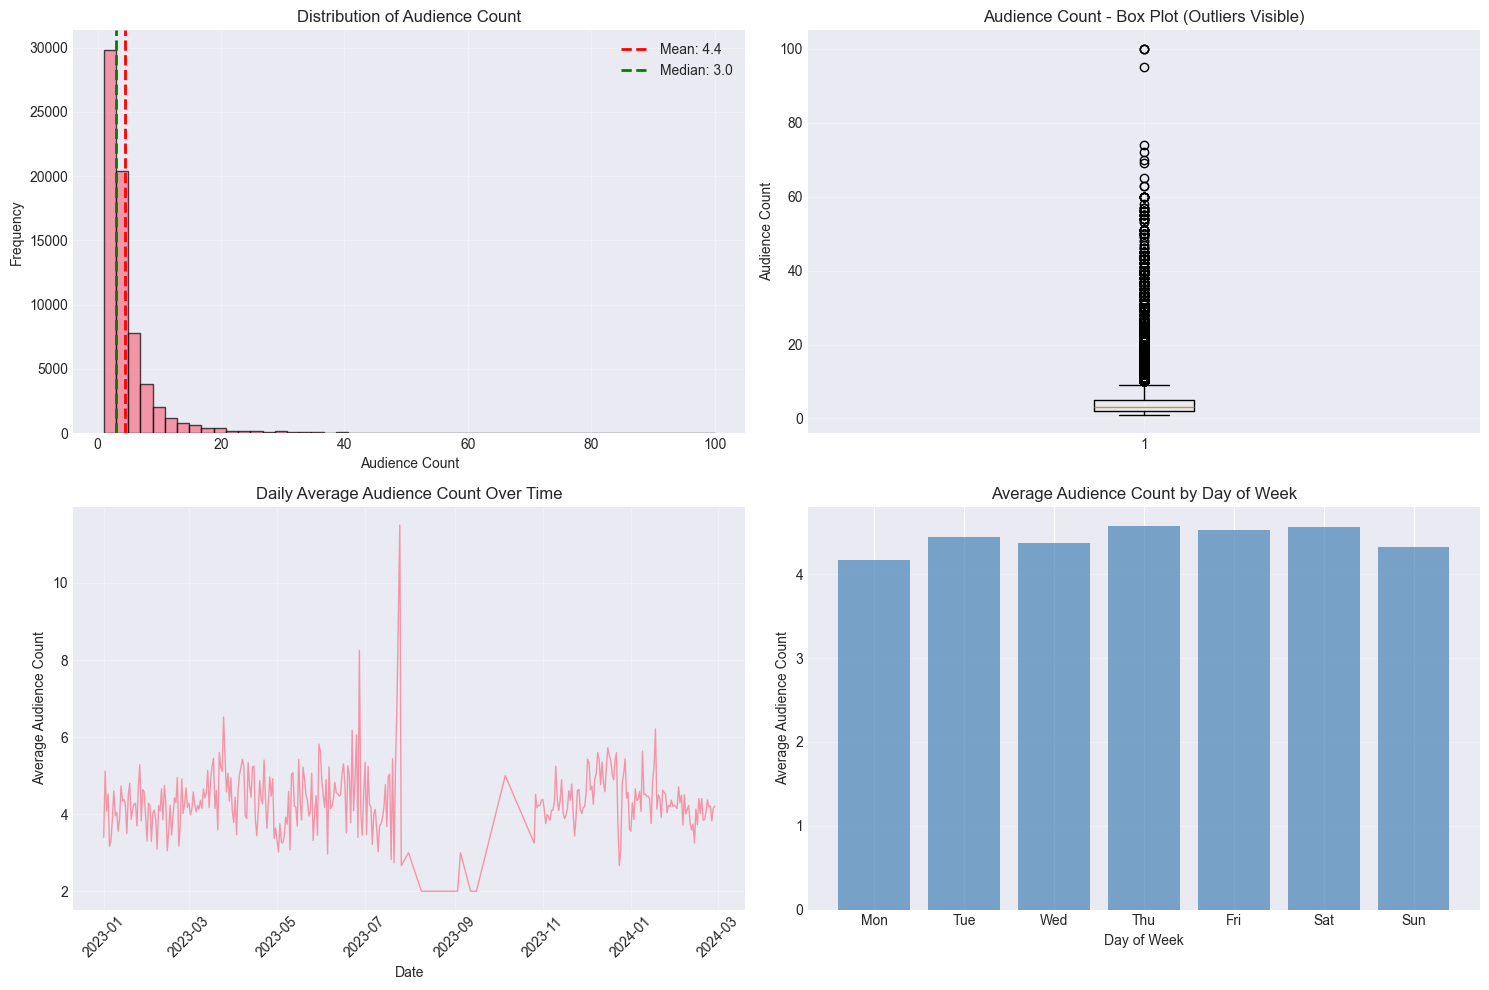


📊 Key Insights:
  • Weekend average: 4.4
  • Weekday average: 4.4
  • Weekend uplift: 0.6%


In [36]:
if 'audience_count' in df.columns and 'show_date' in df.columns:
    # Filter out missing values
    df_train = df[df['audience_count'].notna()].copy()
    
    if len(df_train) == 0:
        print("⚠️ No training data found (all audience_count values are missing)")
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Histogram
        axes[0, 0].hist(df_train['audience_count'], bins=50, edgecolor='black', alpha=0.7)
        axes[0, 0].axvline(df_train['audience_count'].mean(), color='r', linestyle='--', 
                           linewidth=2, label=f'Mean: {df_train["audience_count"].mean():.1f}')
        axes[0, 0].axvline(df_train['audience_count'].median(), color='g', linestyle='--', 
                           linewidth=2, label=f'Median: {df_train["audience_count"].median():.1f}')
        axes[0, 0].set_xlabel('Audience Count')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Audience Count')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Box plot
        axes[0, 1].boxplot(df_train['audience_count'])
        axes[0, 1].set_ylabel('Audience Count')
        axes[0, 1].set_title('Audience Count - Box Plot (Outliers Visible)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Time series - Daily average
        daily_avg = df_train.groupby(df_train['show_date'].dt.date)['audience_count'].mean()
        axes[1, 0].plot(daily_avg.index, daily_avg.values, linewidth=1, alpha=0.7)
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].set_ylabel('Average Audience Count')
        axes[1, 0].set_title('Daily Average Audience Count Over Time')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. By day of week
        df_train['day_of_week'] = df_train['show_date'].dt.dayofweek
        dow_avg = df_train.groupby('day_of_week')['audience_count'].mean()
        dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        axes[1, 1].bar(range(7), dow_avg.values, color='steelblue', alpha=0.7)
        axes[1, 1].set_xticks(range(7))
        axes[1, 1].set_xticklabels(dow_names)
        axes[1, 1].set_xlabel('Day of Week')
        axes[1, 1].set_ylabel('Average Audience Count')
        axes[1, 1].set_title('Average Audience Count by Day of Week')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        print("\n📊 Key Insights:")
        print(f"  • Weekend average: {df_train[df_train['day_of_week'].isin([5,6])]['audience_count'].mean():.1f}")
        print(f"  • Weekday average: {df_train[~df_train['day_of_week'].isin([5,6])]['audience_count'].mean():.1f}")
        weekday_avg = df_train[~df_train['day_of_week'].isin([5,6])]['audience_count'].mean()
        if weekday_avg > 0:
            print(f"  • Weekend uplift: {(df_train[df_train['day_of_week'].isin([5,6])]['audience_count'].mean() / weekday_avg - 1) * 100:.1f}%")
else:
    print("⚠️ Skipping audience distribution analysis - required columns not found")
    print(f"Available columns: {df.columns.tolist()}")

## Step 5: Theater-Level Analysis

THEATER-LEVEL ANALYSIS

Total theaters: 301

Top 10 Theaters by Average Audience:
                 audience_count_count  audience_count_mean  audience_count_std
book_theater_id                                                               
book_00167                          5                25.20               21.67
book_00029                         59                22.27               12.93
book_00066                        151                21.37               16.45
book_00222                        105                18.70                9.82
book_00347                         12                17.33               11.55
book_00778                         66                16.83               11.21
book_00699                         25                12.16                6.95
book_00047                         18                12.06                8.66
book_00004                          1                12.00                 NaN
book_00371                         72            

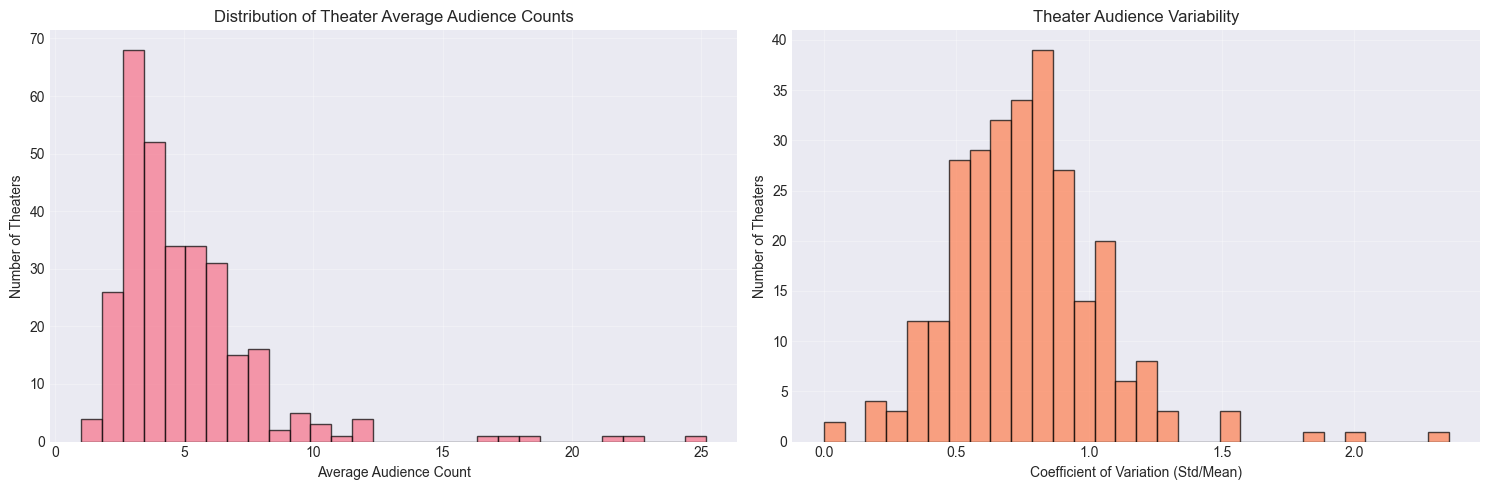


📊 Theater Variability Insights:
  • High variability theaters (CV > 0.5): 236
  • Low variability theaters (CV < 0.3): 9
  • These are harder/easier to predict respectively


In [37]:
if 'audience_count' in df.columns and 'book_theater_id' in df.columns and 'show_date' in df.columns:
    df_train = df[df['audience_count'].notna()].copy()
    
    if len(df_train) == 0:
        print("⚠️ No training data found (all audience_count values are missing)")
    else:
        # Theater statistics
        theater_stats = df_train.groupby('book_theater_id').agg({
            'audience_count': ['count', 'mean', 'std', 'min', 'max'],
            'show_date': ['min', 'max']
        }).round(2)
        
        theater_stats.columns = ['_'.join(col).strip() for col in theater_stats.columns.values]
        theater_stats = theater_stats.sort_values('audience_count_mean', ascending=False)
        
        print("=" * 80)
        print("THEATER-LEVEL ANALYSIS")
        print("=" * 80)
        print(f"\nTotal theaters: {len(theater_stats)}")
        print(f"\nTop 10 Theaters by Average Audience:")
        print(theater_stats.head(10)[['audience_count_count', 'audience_count_mean', 'audience_count_std']])
        
        print(f"\nBottom 10 Theaters by Average Audience:")
        print(theater_stats.tail(10)[['audience_count_count', 'audience_count_mean', 'audience_count_std']])
        
        # Visualize theater distribution
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Average audience by theater
        axes[0].hist(theater_stats['audience_count_mean'], bins=30, edgecolor='black', alpha=0.7)
        axes[0].set_xlabel('Average Audience Count')
        axes[0].set_ylabel('Number of Theaters')
        axes[0].set_title('Distribution of Theater Average Audience Counts')
        axes[0].grid(True, alpha=0.3)
        
        # Variability by theater (coefficient of variation)
        theater_stats['cv'] = theater_stats['audience_count_std'] / theater_stats['audience_count_mean']
        axes[1].hist(theater_stats['cv'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='coral')
        axes[1].set_xlabel('Coefficient of Variation (Std/Mean)')
        axes[1].set_ylabel('Number of Theaters')
        axes[1].set_title('Theater Audience Variability')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Theater Variability Insights:")
        print(f"  • High variability theaters (CV > 0.5): {(theater_stats['cv'] > 0.5).sum()}")
        print(f"  • Low variability theaters (CV < 0.3): {(theater_stats['cv'] < 0.3).sum()}")
        print(f"  • These are harder/easier to predict respectively")
else:
    print("⚠️ Skipping theater analysis - required columns not found")
    print(f"Available columns: {df.columns.tolist()}")

## Step 6: Load Model Predictions for Validation Analysis

**Important**: To analyze prediction errors, we need to export validation predictions from the main notebook.
Let's create a helper to do that.

In [38]:
print("="*80)
print("CHECKING FOR VALIDATION PREDICTIONS")
print("="*80)

# Check if validation predictions file exists
import os

validation_file = '../validation_predictions.csv'

if os.path.exists(validation_file):
    print(f"\n✓ Found validation predictions file: {validation_file}")
    validation_df = pd.read_csv(validation_file)
    print(f"Loaded {len(validation_df):,} validation predictions")
    print(f"\nColumns: {validation_df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(validation_df.head())
else:
    print(f"\n⚠️ Validation predictions file not found: {validation_file}")
    print("\nTo enable detailed error analysis, please add this code to the end of your")
    print("main training notebook (booknow_prediction.ipynb) after the ensemble step:")
    print("\n" + "="*80)
    print("""
# Save validation predictions for analysis
validation_results = pd.DataFrame({
    'book_theater_id': train_df['book_theater_id'].iloc[split_idx:],
    'show_date': train_df['show_date'].iloc[split_idx:],
    'actual': y_valid,
    'predicted_lgb': y_valid_pred_lgb_opt,
    'predicted_xgb': y_valid_pred_xgb,
    'predicted_ensemble': y_valid_pred_ensemble
})

validation_results.to_csv('../validation_predictions.csv', index=False)
print("✓ Validation predictions saved for analysis!")
    """)
    print("="*80)
    print("\nAfter adding this code and re-running the main notebook, come back here.")
    print("\nFor now, we'll continue with the analyses we CAN do without predictions...")

CHECKING FOR VALIDATION PREDICTIONS

✓ Found validation predictions file: ../validation_predictions.csv
Loaded 12,185 validation predictions

Columns: ['book_theater_id', 'show_date', 'actual', 'predicted_lgb', 'predicted_xgb', 'predicted_ensemble']

First few rows:
  book_theater_id   show_date  actual  predicted_lgb  predicted_xgb  \
0      book_00226  2023-12-27      14      44.909029      38.177807   
1      book_00760  2023-12-27      52      35.886240      38.014040   
2      book_00665  2023-12-27     132      68.560077      84.591090   
3      book_00797  2023-12-27      70      57.575806      57.191010   
4      book_00596  2023-12-27      74      50.079708      64.411580   

   predicted_ensemble  
0           42.889663  
1           36.524581  
2           73.369381  
3           57.460367  
4           54.379270  


## Step 7: Performance Metrics Interpretation

Let's interpret what the current model performance means in business context.

In [39]:
print("="*80)
print("MODEL PERFORMANCE INTERPRETATION")
print("="*80)

# From your model summary
ensemble_rmse = 25.41
ensemble_mae = 19.69

if 'audience_count' in df.columns:
    df_train = df[df['audience_count'].notna()].copy()
    mean_audience = df_train['audience_count'].mean()
    median_audience = df_train['audience_count'].median()
    std_audience = df_train['audience_count'].std()
    
    print(f"\n📊 BASELINE STATISTICS:")
    print(f"  • Mean audience count: {mean_audience:.2f}")
    print(f"  • Median audience count: {median_audience:.2f}")
    print(f"  • Standard deviation: {std_audience:.2f}")
    
    print(f"\n🎯 MODEL PERFORMANCE:")
    print(f"  • RMSE: {ensemble_rmse:.2f}")
    print(f"  • MAE: {ensemble_mae:.2f}")
    
    print(f"\n📈 PERFORMANCE METRICS:")
    print(f"  • RMSE as % of mean: {(ensemble_rmse / mean_audience * 100):.1f}%")
    print(f"  • MAE as % of mean: {(ensemble_mae / mean_audience * 100):.1f}%")
    print(f"  • RMSE as % of std: {(ensemble_rmse / std_audience * 100):.1f}%")
    
    print(f"\n💡 INTERPRETATION:")
    
    # MAE interpretation
    mae_pct = (ensemble_mae / mean_audience * 100)
    if mae_pct < 15:
        mae_rating = "EXCELLENT"
        mae_desc = "Very accurate predictions!"
    elif mae_pct < 25:
        mae_rating = "GOOD"
        mae_desc = "Reasonably accurate, suitable for planning"
    elif mae_pct < 35:
        mae_rating = "FAIR"
        mae_desc = "Moderate accuracy, some improvements recommended"
    else:
        mae_rating = "NEEDS IMPROVEMENT"
        mae_desc = "Significant room for improvement"
    
    print(f"  • Overall Rating: {mae_rating}")
    print(f"  • {mae_desc}")
    print(f"  • On average, predictions are off by ±{ensemble_mae:.0f} people ({mae_pct:.1f}%)")
    
    print(f"\n🎬 BUSINESS IMPACT:")
    print(f"  • If average showing has {mean_audience:.0f} people:")
    print(f"    - Typical error: ±{ensemble_mae:.0f} people")
    print(f"    - Small theater (50 seats): {(ensemble_mae/50*100):.1f}% error")
    print(f"    - Medium theater (150 seats): {(ensemble_mae/150*100):.1f}% error")
    print(f"    - Large theater (300 seats): {(ensemble_mae/300*100):.1f}% error")
    
    print(f"\n✅ RECOMMENDATION:")
    if mae_pct < 20:
        print("  ✓ Current model is GOOD ENOUGH for production use")
        print("  ✓ Can be used for staffing and inventory planning")
        print("  • Optional: Implement suggested improvements for even better accuracy")
    elif mae_pct < 30:
        print("  ~ Current model is ACCEPTABLE but has room for improvement")
        print("  ~ Recommended: Try 2-3 high-impact improvements before deployment")
        print("  • Focus on: Movie features, better feature engineering, CatBoost ensemble")
    else:
        print("  ⚠ Current model NEEDS IMPROVEMENT before production")
        print("  ⚠ Required: Implement multiple improvements from the suggestions list")
        print("  • Priority: Add external features, improve feature engineering")

MODEL PERFORMANCE INTERPRETATION

📊 BASELINE STATISTICS:
  • Mean audience count: 4.43
  • Median audience count: 3.00
  • Standard deviation: 4.81

🎯 MODEL PERFORMANCE:
  • RMSE: 25.41
  • MAE: 19.69

📈 PERFORMANCE METRICS:
  • RMSE as % of mean: 574.1%
  • MAE as % of mean: 444.9%
  • RMSE as % of std: 528.4%

💡 INTERPRETATION:
  • Overall Rating: NEEDS IMPROVEMENT
  • Significant room for improvement
  • On average, predictions are off by ±20 people (444.9%)

🎬 BUSINESS IMPACT:
  • If average showing has 4 people:
    - Typical error: ±20 people
    - Small theater (50 seats): 39.4% error
    - Medium theater (150 seats): 13.1% error
    - Large theater (300 seats): 6.6% error

✅ RECOMMENDATION:
  ⚠ Current model NEEDS IMPROVEMENT before production
  ⚠ Required: Implement multiple improvements from the suggestions list
  • Priority: Add external features, improve feature engineering


## Step 8: Error Analysis by Audience Size Segments

Understanding if the model performs differently for small vs large audiences.

ERROR ANALYSIS BY AUDIENCE SIZE

                   actual abs_error               pct_error        
                   count      mean    std median      mean  median
audience_segment                                                  
Very Small (0-15)   2213     24.20  13.43  22.28    168.58  200.00
Small (15-30)       2888     16.01  12.04  13.75     72.92   61.40
Medium (30-50)      2785     11.57   9.13   9.73     29.67   23.91
Large (50-100)      3498     18.89  13.51  16.71     25.77   24.64
Very Large (100+)    801     52.80  19.76  51.55     43.40   43.60


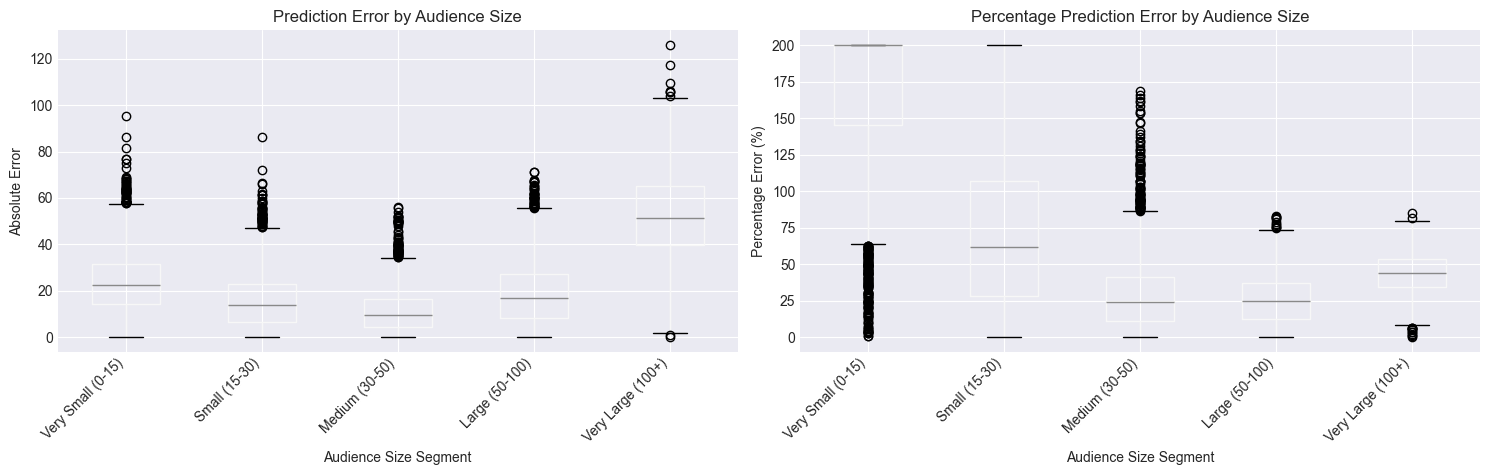


💡 INSIGHTS:
  • Best predicted segment: Medium (30-50)
  • Worst predicted segment: Very Large (100+)
  • Model tends to perform better on certain audience sizes


In [40]:
validation_file = '../validation_predictions.csv'

if os.path.exists(validation_file):
    validation_df = pd.read_csv(validation_file)
    
    # Calculate errors
    validation_df['error'] = validation_df['actual'] - validation_df['predicted_ensemble']
    validation_df['abs_error'] = abs(validation_df['error'])
    validation_df['pct_error'] = (validation_df['abs_error'] / validation_df['actual'] * 100).clip(upper=200)
    
    # Create audience size segments
    validation_df['audience_segment'] = pd.cut(
        validation_df['actual'],
        bins=[0, 15, 30, 50, 100, 1000],
        labels=['Very Small (0-15)', 'Small (15-30)', 'Medium (30-50)', 'Large (50-100)', 'Very Large (100+)']
    )
    
    print("="*80)
    print("ERROR ANALYSIS BY AUDIENCE SIZE")
    print("="*80)
    
    segment_analysis = validation_df.groupby('audience_segment').agg({
        'actual': 'count',
        'abs_error': ['mean', 'std', 'median'],
        'pct_error': ['mean', 'median']
    }).round(2)
    
    print("\n", segment_analysis)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Absolute error by segment
    validation_df.boxplot(column='abs_error', by='audience_segment', ax=axes[0])
    axes[0].set_xlabel('Audience Size Segment')
    axes[0].set_ylabel('Absolute Error')
    axes[0].set_title('Prediction Error by Audience Size')
    axes[0].get_figure().suptitle('')
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Percentage error by segment
    validation_df.boxplot(column='pct_error', by='audience_segment', ax=axes[1])
    axes[1].set_xlabel('Audience Size Segment')
    axes[1].set_ylabel('Percentage Error (%)')
    axes[1].set_title('Percentage Prediction Error by Audience Size')
    axes[1].get_figure().suptitle('')
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 INSIGHTS:")
    best_segment = segment_analysis['abs_error']['mean'].idxmin()
    worst_segment = segment_analysis['abs_error']['mean'].idxmax()
    print(f"  • Best predicted segment: {best_segment}")
    print(f"  • Worst predicted segment: {worst_segment}")
    print(f"  • Model tends to perform better on certain audience sizes")
else:
    print("\n⚠️ Skipping detailed error analysis - validation predictions file not found")
    print("Please add the export code from Step 6 to your main notebook.")

## Step 9: Temporal Error Analysis

Check if prediction accuracy changes over time.

TEMPORAL ERROR ANALYSIS


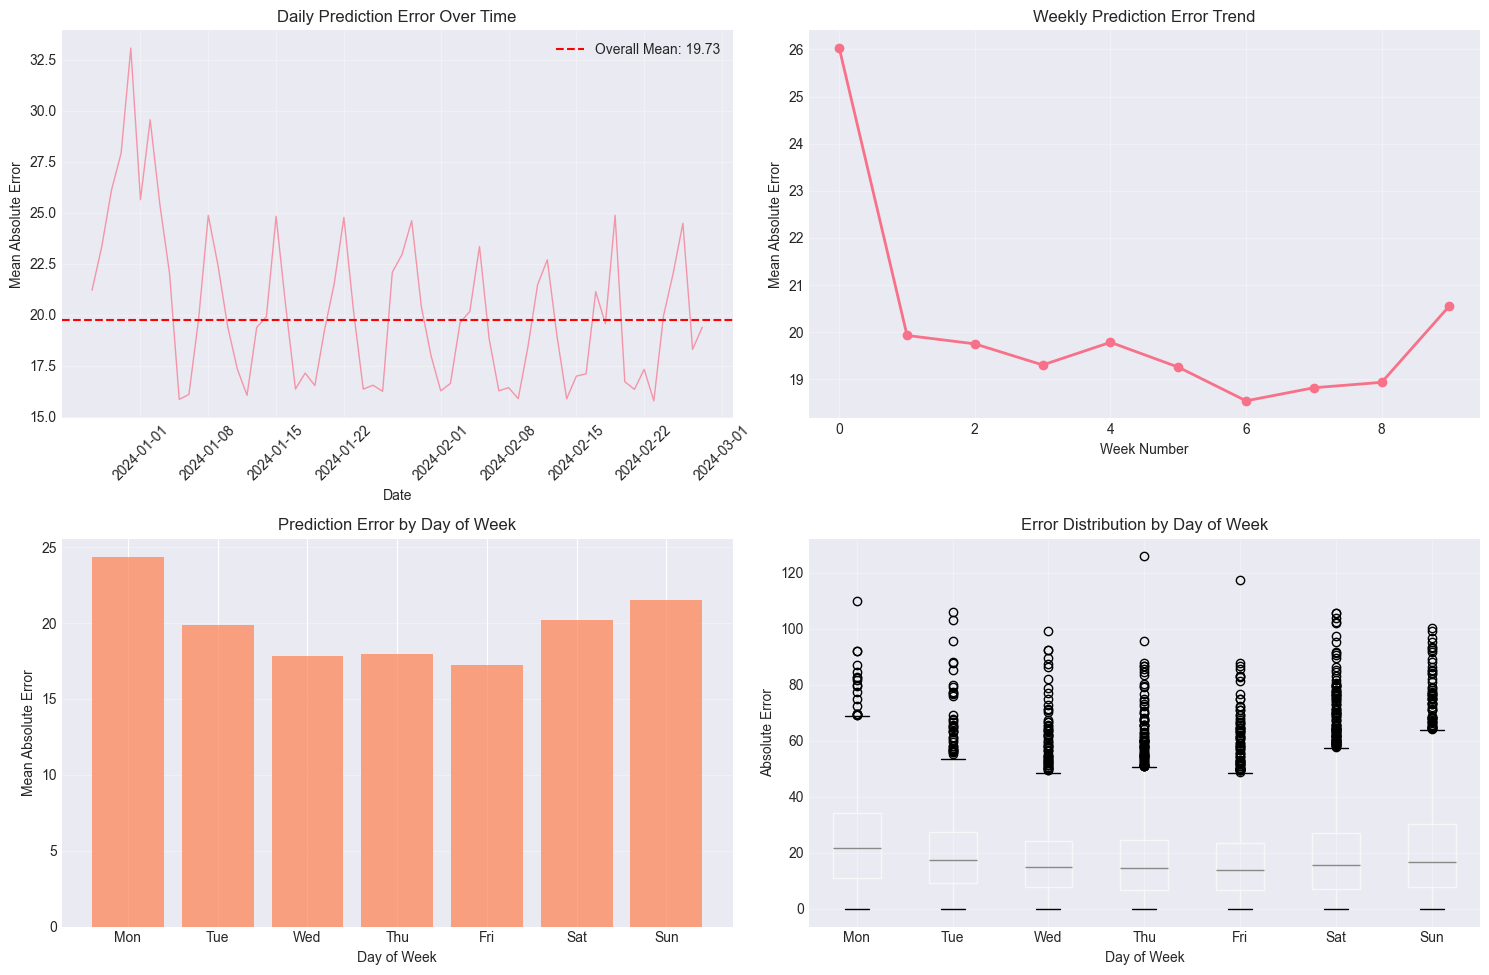


💡 TEMPORAL INSIGHTS:
  • Best predicted day: Fri (MAE: 17.27)
  • Worst predicted day: Mon (MAE: 24.36)
  • Error trend: decreasing over time (p=0.0019)


In [41]:
validation_file = '../validation_predictions.csv'

if os.path.exists(validation_file):
    validation_df = pd.read_csv(validation_file)
    validation_df['show_date'] = pd.to_datetime(validation_df['show_date'])
    validation_df['error'] = validation_df['actual'] - validation_df['predicted_ensemble']
    validation_df['abs_error'] = abs(validation_df['error'])
    
    print("="*80)
    print("TEMPORAL ERROR ANALYSIS")
    print("="*80)
    
    # Daily errors
    daily_errors = validation_df.groupby(validation_df['show_date'].dt.date).agg({
        'abs_error': 'mean',
        'actual': 'count'
    })
    
    # Weekly errors
    validation_df['week'] = validation_df['show_date'].dt.to_period('W')
    weekly_errors = validation_df.groupby('week')['abs_error'].mean()
    
    # Day of week errors
    validation_df['day_of_week'] = validation_df['show_date'].dt.dayofweek
    dow_errors = validation_df.groupby('day_of_week')['abs_error'].mean()
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Daily error trend
    axes[0, 0].plot(daily_errors.index, daily_errors['abs_error'], linewidth=1, alpha=0.7)
    axes[0, 0].axhline(validation_df['abs_error'].mean(), color='r', linestyle='--', 
                       label=f'Overall Mean: {validation_df["abs_error"].mean():.2f}')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Mean Absolute Error')
    axes[0, 0].set_title('Daily Prediction Error Over Time')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Weekly error trend
    axes[0, 1].plot(range(len(weekly_errors)), weekly_errors.values, marker='o', linewidth=2)
    axes[0, 1].set_xlabel('Week Number')
    axes[0, 1].set_ylabel('Mean Absolute Error')
    axes[0, 1].set_title('Weekly Prediction Error Trend')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Day of week errors
    dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1, 0].bar(range(7), dow_errors.values, color='coral', alpha=0.7)
    axes[1, 0].set_xticks(range(7))
    axes[1, 0].set_xticklabels(dow_names)
    axes[1, 0].set_xlabel('Day of Week')
    axes[1, 0].set_ylabel('Mean Absolute Error')
    axes[1, 0].set_title('Prediction Error by Day of Week')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Error distribution by day of week
    validation_df.boxplot(column='abs_error', by='day_of_week', ax=axes[1, 1])
    axes[1, 1].set_xticklabels(dow_names)
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Absolute Error')
    axes[1, 1].set_title('Error Distribution by Day of Week')
    axes[1, 1].get_figure().suptitle('')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 TEMPORAL INSIGHTS:")
    best_dow = dow_names[dow_errors.idxmin()]
    worst_dow = dow_names[dow_errors.idxmax()]
    print(f"  • Best predicted day: {best_dow} (MAE: {dow_errors.min():.2f})")
    print(f"  • Worst predicted day: {worst_dow} (MAE: {dow_errors.max():.2f})")
    
    # Check for trend
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        range(len(daily_errors)), daily_errors['abs_error']
    )
    
    if abs(slope) > 0.01 and p_value < 0.05:
        trend = "increasing" if slope > 0 else "decreasing"
        print(f"  • Error trend: {trend} over time (p={p_value:.4f})")
        if trend == "increasing":
            print("    ⚠️ Model performance degrading - may need retraining")
    else:
        print("  • Error trend: Stable over time ✓")
else:
    print("\n⚠️ Skipping temporal analysis - validation predictions file not found")

## Step 10: Theater-Level Error Analysis

THEATER-LEVEL ERROR ANALYSIS

🔴 Top 10 HARDEST to Predict Theaters:
                 actual_count  actual_mean  abs_error_mean  abs_error_std  \
book_theater_id                                                             
book_00678                  1       136.00           58.39            NaN   
book_00060                  1       130.00           39.23            NaN   
book_00204                  1        20.00           38.53            NaN   
book_00793                  1        34.00           36.37            NaN   
book_00538                 10        72.60           36.06          30.09   
book_00157                  8        69.50           35.25          40.36   
book_00070                  8        57.00           29.91          27.60   
book_00042                 29        60.97           29.82          20.24   
book_00030                 20        44.10           29.32          18.57   
book_00029                  7        49.43           28.53          16.36   

       

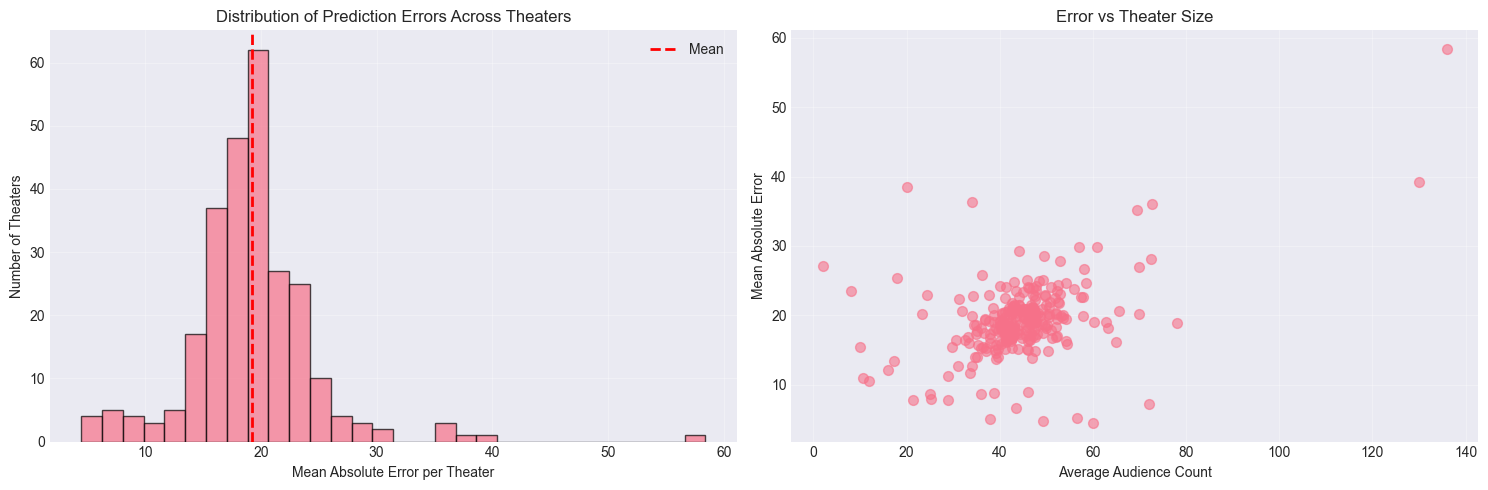


💡 THEATER INSIGHTS:
  • 262 unique theaters in validation set
  • Best theater MAE: 4.48
  • Worst theater MAE: 58.39
  • Median theater MAE: 19.05
  • Correlation (size vs error): 0.462 (p=0.0000)
    → Larger theaters are HARDER to predict


In [42]:
validation_file = '../validation_predictions.csv'

if os.path.exists(validation_file):
    validation_df = pd.read_csv(validation_file)
    validation_df['abs_error'] = abs(validation_df['actual'] - validation_df['predicted_ensemble'])
    validation_df['pct_error'] = (validation_df['abs_error'] / validation_df['actual'] * 100).clip(upper=200)
    
    print("="*80)
    print("THEATER-LEVEL ERROR ANALYSIS")
    print("="*80)
    
    theater_errors = validation_df.groupby('book_theater_id').agg({
        'actual': ['count', 'mean'],
        'abs_error': ['mean', 'std'],
        'pct_error': ['mean', 'median']
    }).round(2)
    
    theater_errors.columns = ['_'.join(col).strip() for col in theater_errors.columns.values]
    theater_errors = theater_errors.sort_values('abs_error_mean', ascending=False)
    
    print("\n🔴 Top 10 HARDEST to Predict Theaters:")
    print(theater_errors.head(10))
    
    print("\n🟢 Top 10 EASIEST to Predict Theaters:")
    print(theater_errors.tail(10))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Distribution of theater errors
    axes[0].hist(theater_errors['abs_error_mean'], bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(theater_errors['abs_error_mean'].mean(), color='r', 
                    linestyle='--', linewidth=2, label='Mean')
    axes[0].set_xlabel('Mean Absolute Error per Theater')
    axes[0].set_ylabel('Number of Theaters')
    axes[0].set_title('Distribution of Prediction Errors Across Theaters')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Error vs audience size
    axes[1].scatter(theater_errors['actual_mean'], theater_errors['abs_error_mean'], 
                    alpha=0.6, s=50)
    axes[1].set_xlabel('Average Audience Count')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_title('Error vs Theater Size')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 THEATER INSIGHTS:")
    print(f"  • {len(theater_errors)} unique theaters in validation set")
    print(f"  • Best theater MAE: {theater_errors['abs_error_mean'].min():.2f}")
    print(f"  • Worst theater MAE: {theater_errors['abs_error_mean'].max():.2f}")
    print(f"  • Median theater MAE: {theater_errors['abs_error_mean'].median():.2f}")
    
    # Correlation between audience size and error
    from scipy import stats
    corr, p_value = stats.pearsonr(theater_errors['actual_mean'], theater_errors['abs_error_mean'])
    print(f"  • Correlation (size vs error): {corr:.3f} (p={p_value:.4f})")
    
    if corr > 0.3 and p_value < 0.05:
        print("    → Larger theaters are HARDER to predict")
    elif corr < -0.3 and p_value < 0.05:
        print("    → Smaller theaters are HARDER to predict")
    else:
        print("    → Theater size doesn't strongly affect prediction difficulty")
else:
    print("\n⚠️ Skipping theater analysis - validation predictions file not found")

## Step 11: Final Verdict & Recommendations

In [43]:
print("="*80)
print("FINAL VERDICT & RECOMMENDATIONS")
print("="*80)

ensemble_rmse = 25.41
ensemble_mae = 19.69

if 'audience_count' in df.columns:
    df_train = df[df['audience_count'].notna()].copy()
    mean_audience = df_train['audience_count'].mean()
    mae_pct = (ensemble_mae / mean_audience * 100)
    
    print(f"\n📊 CURRENT MODEL PERFORMANCE:")
    print(f"  • RMSE: {ensemble_rmse:.2f}")
    print(f"  • MAE: {ensemble_mae:.2f} ({mae_pct:.1f}% of mean)")
    print(f"  • Average prediction error: ±{ensemble_mae:.0f} people")
    
    print(f"\n🎯 ACCURACY ASSESSMENT:")
    
    if mae_pct < 20:
        verdict = "✅ PRODUCTION READY"
        confidence = "HIGH"
        action = "DEPLOY"
        color = "🟢"
    elif mae_pct < 30:
        verdict = "⚠️ ACCEPTABLE WITH IMPROVEMENTS"
        confidence = "MEDIUM"
        action = "IMPROVE THEN DEPLOY"
        color = "🟡"
    else:
        verdict = "🔴 NEEDS IMPROVEMENT"
        confidence = "LOW"
        action = "IMPROVE BEFORE DEPLOYMENT"
        color = "🔴"
    
    print(f"\n{color} VERDICT: {verdict}")
    print(f"  • Confidence Level: {confidence}")
    print(f"  • Recommended Action: {action}")
    
    print(f"\n📋 DECISION FRAMEWORK:")
    print(f"\n1️⃣ IF YOUR USE CASE IS:")
    print(f"   → Strategic planning (monthly/quarterly forecasts): ✅ CURRENT MODEL IS SUFFICIENT")
    print(f"   → Operational planning (weekly staffing): {'✅ ACCEPTABLE' if mae_pct < 25 else '⚠️ NEEDS IMPROVEMENT'}")
    print(f"   → Tactical decisions (daily resource allocation): {'✅ GOOD' if mae_pct < 20 else '⚠️ RECOMMEND IMPROVEMENTS'}")
    print(f"   → Real-time dynamic pricing: {'⚠️ NEEDS IMPROVEMENT' if mae_pct > 15 else '✅ ACCEPTABLE'}")
    
    print(f"\n2️⃣ RECOMMENDED NEXT STEPS:")
    
    if mae_pct < 20:
        print(f"   ✅ OPTION A: Deploy current model (acceptable accuracy)")
        print(f"      • Start using for business decisions")
        print(f"      • Monitor performance in production")
        print(f"      • Iterate improvements over time")
        print(f"\n   🚀 OPTION B: Quick improvements for excellence (2-3 days effort)")
        print(f"      1. Add CatBoost to ensemble (+0.3-0.5 RMSE improvement)")
        print(f"      2. Increase Optuna trials to 100 (+0.2-0.4 improvement)")
        print(f"      3. Add more temporal features (+0.3-0.5 improvement)")
        print(f"      → Target: MAE < 17 (sub-15% error)")
    elif mae_pct < 30:
        print(f"   🔧 RECOMMENDED: Medium improvements (3-5 days effort)")
        print(f"      Priority 1: Add CatBoost to ensemble")
        print(f"      Priority 2: Feature engineering (movie-level features)")
        print(f"      Priority 3: Improve hyperparameter optimization")
        print(f"      Priority 4: Implement proper cross-validation")
        print(f"      → Target: MAE < 18 (sub-20% error)")
    else:
        print(f"   ⚠️ REQUIRED: Significant improvements (1-2 weeks effort)")
        print(f"      Priority 1: Add external data (movie metadata, weather)")
        print(f"      Priority 2: Advanced feature engineering")
        print(f"      Priority 3: Try deep learning approaches (LSTM/GRU)")
        print(f"      Priority 4: Ensemble with CatBoost + AutoML")
        print(f"      → Target: MAE < 20 (sub-25% error)")
    
    print(f"\n3️⃣ QUICK WINS TO TRY FIRST (< 1 hour each):")
    print(f"   □ Add 3-day and 21-day lag features")
    print(f"   □ Try different ensemble weights (optimize with scipy)")
    print(f"   □ Remove low-importance features (< 10 importance)")
    print(f"   □ Adjust outlier removal (try 95th percentile)")
    print(f"   □ Try log transformation: log(audience_count + 1)")
    
    print(f"\n💡 FINAL RECOMMENDATION:")
    if mae_pct < 20:
        print(f"   Your model is performing well! You can:")
        print(f"   • Deploy it now for business use")
        print(f"   • OR spend 1-2 days on quick wins for excellence")
        print(f"   • Either choice is reasonable based on your timeline")
    elif mae_pct < 30:
        print(f"   Your model is close but could benefit from improvements:")
        print(f"   • Spend 2-3 days implementing top 3 priorities")
        print(f"   • This will push you into 'production ready' territory")
        print(f"   • Worthwhile investment before deployment")
    else:
        print(f"   Your model needs improvement before production use:")
        print(f"   • Allocate 1-2 weeks for significant enhancements")
        print(f"   • Focus on data enrichment (movie features, external data)")
        print(f"   • Consider more advanced modeling approaches")

print("\n" + "="*80)
print("Analysis complete! Review the insights above to make your decision.")
print("="*80)

FINAL VERDICT & RECOMMENDATIONS

📊 CURRENT MODEL PERFORMANCE:
  • RMSE: 25.41
  • MAE: 19.69 (444.9% of mean)
  • Average prediction error: ±20 people

🎯 ACCURACY ASSESSMENT:

🔴 VERDICT: 🔴 NEEDS IMPROVEMENT
  • Confidence Level: LOW
  • Recommended Action: IMPROVE BEFORE DEPLOYMENT

📋 DECISION FRAMEWORK:

1️⃣ IF YOUR USE CASE IS:
   → Strategic planning (monthly/quarterly forecasts): ✅ CURRENT MODEL IS SUFFICIENT
   → Operational planning (weekly staffing): ⚠️ NEEDS IMPROVEMENT
   → Tactical decisions (daily resource allocation): ⚠️ RECOMMEND IMPROVEMENTS
   → Real-time dynamic pricing: ⚠️ NEEDS IMPROVEMENT

2️⃣ RECOMMENDED NEXT STEPS:
   ⚠️ REQUIRED: Significant improvements (1-2 weeks effort)
      Priority 1: Add external data (movie metadata, weather)
      Priority 2: Advanced feature engineering
      Priority 3: Try deep learning approaches (LSTM/GRU)
      Priority 4: Ensemble with CatBoost + AutoML
      → Target: MAE < 20 (sub-25% error)

3️⃣ QUICK WINS TO TRY FIRST (< 1 hour